# About 
This notebook analyzes Boer-Mulders from CLAS data.  The following options can be configured.
- Include HERMES data or not 
- Run single fit or nested sampling
- Fit Collins or use the SIA result

In [1]:
import copy 
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import pylab as py
import sys

from fitlab.mcsamp import MCSAMP
from fitlab.maxlike import ML 
from fitlab.resman import RESMAN
from tools.config import load_config, conf
from tools.tools import load, save, checkdir

%matplotlib inline

In [2]:
if 'FITPACK' not in os.environ:
    print('Please set environment variable FITPACK to the root directory for this repo.')
else:
    print('Your FITPACK environment is %s' % os.environ['FITPACK'])

Your FITPACK environment is /home/dmriser/repos/fitpack


### Options Setup
The following cell is used to specify options that will be used in the notebook execution.

In [3]:
USE_HERMES   = True 
FIT_COLLINS  = True
FIT_TYPE     = 'nested'
path2results = 'sidis_boermulders_combined_pass0'

### Library Instantiation and Setup
The following cells are used for setting up the datasets, parameters, and fitter.  The only changes necessary are to the fixed/free status of the parameters and their boundaries.

In [4]:
checkdir(path2results)
conf['datasets'] = {}

In [5]:
def setup_datasets(dataset_indices):
    conf['datasets']['sidis']={}
    conf['datasets']['sidis']['filters']={0:{'idx':None,'filter':None}}
    conf['datasets']['sidis']['filters'][0]['filter']='z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9'

    conf['datasets']['sidis']['filters'][0]['idx'] = []
    for index in dataset_indices:
        conf['datasets']['sidis']['filters'][0]['idx'].append(index)

    conf['datasets']['sidis']['xlsx']={}
    for dataset_index in conf['datasets']['sidis']['filters'][0]['idx']:
        conf["datasets"]["sidis"]["xlsx"][dataset_index] = 'sidis/expdata/%d.xlsx' % dataset_index     

    conf['datasets']['sidis']['norm']={}
    for k in conf['datasets']['sidis']['xlsx']: 
        conf['datasets']['sidis']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 

In [6]:
# These datasets are the CLAS data.
active_datasets = [7002, 7003]

if USE_HERMES:
    active_datasets.extend([5019, 5020, 5023, 5024]) 
    
print('Loading... ', active_datasets)

('Loading... ', [7002, 7003, 5019, 5020, 5023, 5024])


In [7]:
setup_datasets(active_datasets)

In [8]:
conf['params'] = {}
conf['shape']  = 1

In [9]:
def configure_collins_fixed():
    conf['params']['collins'] = {}
    conf['params']['collins']['widths0 pi+ fav']     = {'value':0.07249,'fixed':True,'min':1e-5,'max':1}
    conf['params']['collins']['widths0 pi+ unfav']   = {'value':0.10606,'fixed':True,'min':1e-5,'max':2}
    conf['params']['collins']['pi+ u N 1']  = {'value': 1.05988,'fixed':True,'min':0,'max':20}
    conf['params']['collins']['pi+ u a 1']  = {'value':-1.56637,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ u b 1']  = {'value': 4.76009 ,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ d N 1']  = {'value':-6.64443,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 1']  = {'value': 3.45852,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 1']  = {'value': 3.11503 ,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

    conf['params']['collins']['pi+ u N 2']  = {'value': 8.64876,'fixed':True,'min':0,'max':20}
    conf['params']['collins']['pi+ u a 2']  = {'value': 4.31424,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ u b 2']  = {'value': 3.59918,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ d N 2']  = {'value': 0.0,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 2']  = {'value': 0.0,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 2']  = {'value': 0.0,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

def configure_collins_free():
    conf['params']['collins']={}
    conf['params']['collins']['widths0 pi+ fav']     = {'value':7.47958632885192820083e-02,'fixed':False,'min':0.05,'max':0.10}
    conf['params']['collins']['widths0 pi+ unfav']   = {'value':0.059763576917398841815e+00,'fixed':False,'min':0.05,'max':0.136784756168045196212}
    conf['params']['collins']['pi+ u N 1']  = {'value': 4.49239476315589936206e+00,'fixed':False,'min':0,'max':3}
    conf['params']['collins']['pi+ u a 1']  = {'value':-8.28098465048009213518e-01,'fixed':False,'min':-1.9,'max':0}
    conf['params']['collins']['pi+ u b 1']  = {'value': 6.60780815284983358282e+00,'fixed':False,'min':2,'max':6}
    conf['params']['collins']['pi+ d N 1']  = {'value':-4.14852904854067539020e+00,'fixed':False,'min':-12,'max':0.0}
    conf['params']['collins']['pi+ d a 1']  = {'value': 1.00000000000000000000e+00,'fixed':False,'min': 0,'max':7.0}
    conf['params']['collins']['pi+ d b 1']  = {'value': 2.37348461151638101541e+00,'fixed':False,'min':2.5,'max':4.0}

    conf['params']['collins']['pi+ u c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 1']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

    conf['params']['collins']['pi+ u N 2']  = {'value': 6.11150078306284516572e+00,'fixed':False,'min':0,'max':15}
    conf['params']['collins']['pi+ u a 2']  = {'value': 4.71508421683099232524e+00,'fixed':False,'min':1,'max':8.0}
    conf['params']['collins']['pi+ u b 2']  = {'value': 2.75387728005980081392e+00,'fixed':False,'min':0,'max':5}

    conf['params']['collins']['pi+ d N 2']  = {'value': 0.0,'fixed':True,'min':-20,'max':0}
    conf['params']['collins']['pi+ d a 2']  = {'value': 0.0,'fixed':True,'min':-1,'max':5}
    conf['params']['collins']['pi+ d b 2']  = {'value': 0.0,'fixed':True,'min':1e-5,'max':10}
    conf['params']['collins']['pi+ u c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d c 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ u d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}
    conf['params']['collins']['pi+ d d 2']  = {'value': 0.0,'fixed':True,'min':-10,'max':10}

In [10]:
def configure_boermulders():
    conf['params']['boermulders']={}
    conf['params']['boermulders']['widths0 valence'] = {'value':2.99994257869736280497e-01,'fixed':False,'min':1e-5,'max':1}
    conf['params']['boermulders']['widths0 sea']     = {'value':2.32794366294785171068e-01,'fixed':False,'min':1e-5,'max':1}

    conf['params']['boermulders']['u N']  = {'value':5.42650693708019993267e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['u a']  = {'value':1.61391852452949091656e+00,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['u b']  = {'value':1.13975971617359173038e+00,'fixed':False,'min':1e-5,'max':10}
    conf['params']['boermulders']['d N']  = {'value':7.33483204762133667032e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['d a']  = {'value':1.96985180239880541819e-01,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['d b']  = {'value':1.00000000000000008180e-01,'fixed':False,'min':1e-5,'max':10}
    conf['params']['boermulders']['s N']  = {'value':1.00000000000000000000e+00,'fixed':False,'min':-10,'max':10}
    conf['params']['boermulders']['s a']  = {'value':1.00000000000000008180e+00,'fixed':False,'min':-1,'max':5}
    conf['params']['boermulders']['s b']  = {'value':1.00000000000000008180e+00,'fixed':False,'min':1e-5,'max':10}

    conf['params']['boermulders']['u c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['u d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['d c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['d d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['s c']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}
    conf['params']['boermulders']['s d']  = {'value':0.00000000000000000000e+00,'fixed':True,'min':-10,'max':10}

In [11]:
configure_boermulders()

if FIT_COLLINS:
    configure_collins_free() 
else:
    configure_collins_fixed() 

In [12]:
def summarize_parameter_setup():
    for function_name in conf['params'].keys():
        print(function_name)
        
        for parameter in conf['params'][function_name]:
            fixed_status = 'fixed' if conf['params'][function_name][parameter]['fixed'] else 'free'
            print('{0:<24} {1:<8}'.format(parameter, fixed_status))

In [13]:
summarize_parameter_setup()

boermulders
s N                      free    
d c                      fixed   
d b                      free    
d a                      free    
d N                      free    
s b                      free    
s c                      fixed   
s d                      fixed   
u N                      free    
d d                      fixed   
s a                      free    
u d                      fixed   
widths0 sea              free    
u b                      free    
u c                      fixed   
widths0 valence          free    
u a                      free    
collins
pi+ d N 2                fixed   
pi+ d N 1                free    
widths0 pi+ unfav        free    
widths0 pi+ fav          free    
pi+ d c 2                fixed   
pi+ u a 2                free    
pi+ u b 2                free    
pi+ u b 1                free    
pi+ u N 2                free    
pi+ u N 1                free    
pi+ u c 2                fixed   
pi+ u c 1                fix

In [14]:
conf['ncpus']  = 1
conf['resman'] = RESMAN()
mcsamp         = MCSAMP()
maxlike        = ML() 

loading sidis data sets 5023
multiprocess setup: ncpus=1 / observable


### Start Running 
This cell will start the execution of the fitting.

In [15]:
if FIT_TYPE is 'single':
    maxlike.run_minimize(); 

elif FIT_TYPE is 'nested':
    conf['size']   = 8
    conf['factor'] = 3 
    conf['tol'] = 1e-5
    mcsamp.run(path2results)
else:
    print('Fit type not recognized %s' % FIT_TYPE)

iter=4317  logz=-339.671 rel-err=9.997e-06  t-elapsed=1.413e+03  dchi2min=6.788e+02 dchi2max=6.789e+02

### To Do 
- Add plotting package for Boer-Mulders
- Add plotting for CLAS data
- Add plotting for HERMES data

In [16]:
MC=mcsamp.get_MC_samples(path2results+'/mcdata')

runs max likelihoods
339.96275388083404
358.34073729221427
343.2607802817587
339.9855179481834
341.9436493797971
336.52611633287574
342.7817240139
339.45128773226827
sample  size= 29196
sample2 size= 3398


In [17]:
os.listdir(path2results+'/mcdata')

['0.dat', '7.dat', '3.dat', '6.dat', '1.dat', '2.dat', '4.dat', '5.dat']

     widths0 valence =    0.79909 +/-    0.09693
         widths0 sea =    0.47993 +/-    0.06766
                 u N =    5.39843 +/-    1.53106
                 u a =    1.65815 +/-    0.20773
                 u b =    7.23119 +/-    0.73348
                 d N =   -4.27789 +/-    1.30001
                 d a =    0.67021 +/-    0.27409
                 d b =    8.34891 +/-    0.92319
                 s N =    6.99895 +/-    1.12118
                 s a =    1.56902 +/-    0.14186
                 s b =    5.33098 +/-    0.27625


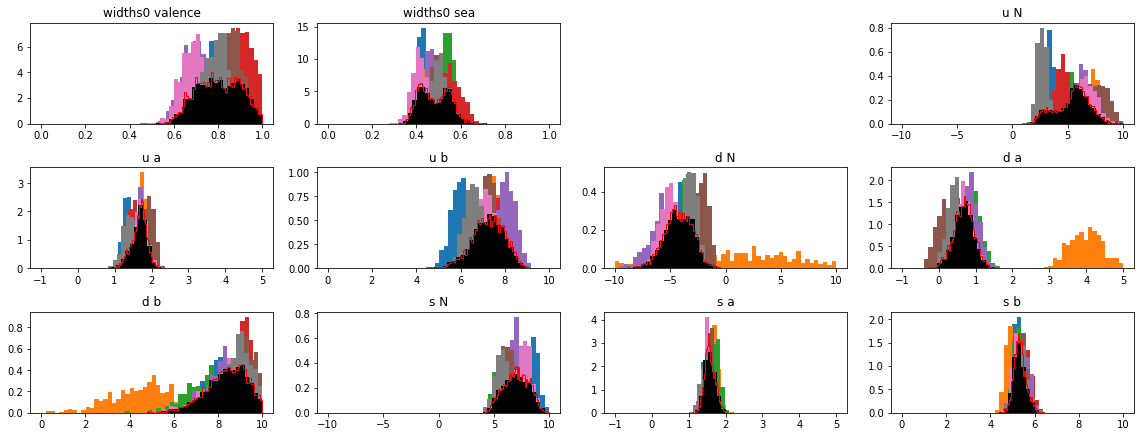

In [18]:
samples=MC['samples']
samples2=MC['samples2']
weights=MC['weights']
weights2=MC['weights2']
order=MC['order']
runs=MC['runs']

nrows,ncols=10,4
fig = py.figure(figsize=(ncols*4,nrows*2))

def get_idx(key,tag):
    for i in range(len(order)):
        if order[i][1]==key and order[i][2]==tag:
            return i

global cnt
cnt=0
def plot(tags):
    global cnt
    for i in range(1,len(tags)):
        cnt+=1
        if tags[i]==None: continue
        idx=get_idx(tags[0],tags[i])
        ax=py.subplot(nrows,ncols,cnt)
        vmin=np.amin(samples2.T[idx])
        vmax=np.amax(samples2.T[idx])
        R=None#(vmin,vmax)
        for k in runs:
            ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        ax.hist(samples.T[idx],weights=weights,bins=50,color='k',normed=True,range=R)
        ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        ax.set_title(tags[i])
        mean=np.einsum('i,i',samples2.T[idx],weights2)
        std=np.einsum('i,i',(samples2.T[idx]-mean)**2,weights2)**0.5
        print '%20s = %10.5f +/- %10.5f'%(tags[i],mean,std)
        #ax.set_xlim(vmin,vmax)
    py.tight_layout()

plot(['boermulders','widths0 valence','widths0 sea',None])
plot(['boermulders','u N','u a','u b'])
plot(['boermulders','d N','d a','d b'])
plot(['boermulders','s N','s a','s b'])

In [19]:
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()

In [20]:
data={'weights':MC['weights2']}
cnt=0
for s in MC['samples2']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(MC['samples2'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].sidisres.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].sidisres.tabs[k]['thy']    
        norm=conf['datasets']['sidis']['norm'][k]['value']
        shift=conf['resman'].sidisres.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'%s/%s'%(path2results,'sidis.dat'))   

3398/3398

In [21]:
data=load('%s/%s'%(path2results,'sidis.dat'))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [22]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: 
        delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(path2results,'data_and_thy.dat'))

sidis


In [23]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2      rchi2      nchi2
   5024   deuteron        pi+     HERMES    AUUcos2     9       7.45       0.00       0.00
   5019     proton        pi-     HERMES    AUUcos2     4       2.25       0.00       0.00
   7002     proton        pi-       CLAS    AUUcos2   117     263.19       0.00       0.00
   7003     proton        pi+       CLAS    AUUcos2   267     734.13       0.00       0.00
   5020     proton        pi+     HERMES    AUUcos2     9      94.36       0.00       0.00
   5023   deuteron        pi-     HERMES    AUUcos2     4       1.20       0.00       0.00


In [24]:
data = {}

for key, value in conf['resman'].sidisres.tabs.iteritems():
    data[key] = pd.DataFrame(value)

### Plot Data vs. Theory

In [25]:
data[7002].columns

Index([      u'Ebeam',           u'N',          u'Q2',       u'Shift',
                u'W2',       u'alpha',         u'col',        u'dthy',
                u'dy',      u'hadron',         u'obs',          u'pT',
            u'pt_bin',      u'q2_bin', u'r-residuals',   u'residuals',
             u'shift',      u'stat_u',      u'target',         u'thy',
             u'value',           u'x',       u'x_bin',           u'y',
                u'yh',          u'yp',           u'z',       u'z_bin'],
      dtype='object')

In [26]:
plt.rc('font', family='serif')

# Keep this option off until
# making final plots, it makes 
# a system call to the latex 
# compiler and is slow, but
# looks much better.
# plt.rc('text', usetex=True)


# These didn't look good, but were 
# recommended.
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

In [27]:
q2_bins = np.unique(data[7002].q2_bin)
x_bins = np.unique(data[7002].x_bin)
pt_bins = np.unique(data[7002].pt_bin)
z_bins = np.unique(data[7002].z_bin)

In [28]:
def plot_clas_pt(data1, data2=None,
                 xbin=0, q2bin=0, zbin=0, ax=None):
    
    # Get subset of data for bin
    query_string = 'x_bin == %d and q2_bin == %d and z_bin == %d' \
        % (xbin, q2bin, zbin)
    d1 = data1.query(query_string)
    
    if data2 is not None:
        d2 = data2.query(query_string)
    
    fig = plt.figure( figsize=(4,3) )
    
    # Draw data
    if ax is None:
        ax = fig.add_subplot(1, 1, 1)
    
    if len(d1) > 0:
        ax.errorbar(x=d1.pT, y=d1.value, yerr=d1.alpha, 
                   marker='o', color='red', linestyle='')
    
        # Draw theory 
        ax.plot(d1.pT, d1.thy, color='red')
        ax.fill_between(d1.pT, d1.thy-d1.dthy, d1.thy+d1.dthy, 
                       color='red', alpha=0.5)
    
    if data2 is not None and len(d2) > 0:
        ax.errorbar(x=d2.pT, y=d2.value, yerr=d2.alpha,                    
                    marker='o', color='blue', linestyle='')
    
        # Draw theory 
        ax.plot(d2.pT, d2.thy, color='blue')
        ax.fill_between(d2.pT, d2.thy-d2.dthy, d2.thy+d2.dthy, 
                       color='blue', alpha=0.5)
        
    # label 
    ax.set_xlabel('$P_{T} \; [GeV/c]$')
    ax.set_ylabel('$A_{UU}^{cos(2\phi)}$')
    ax.set_ylim([-0.2, 0.2])
    
    if len(d1) > 0:
        title_string = '(x, $Q^2$, z) = (%.2f, %.2f, %.2f)' % (d1.x.values[0], d1.Q2.values[0], d1.z.values[0])
        ax.set_title(title_string)

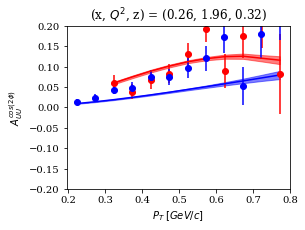

In [29]:
plot_clas_pt(data[7002], data[7003], 1, 1, 6)

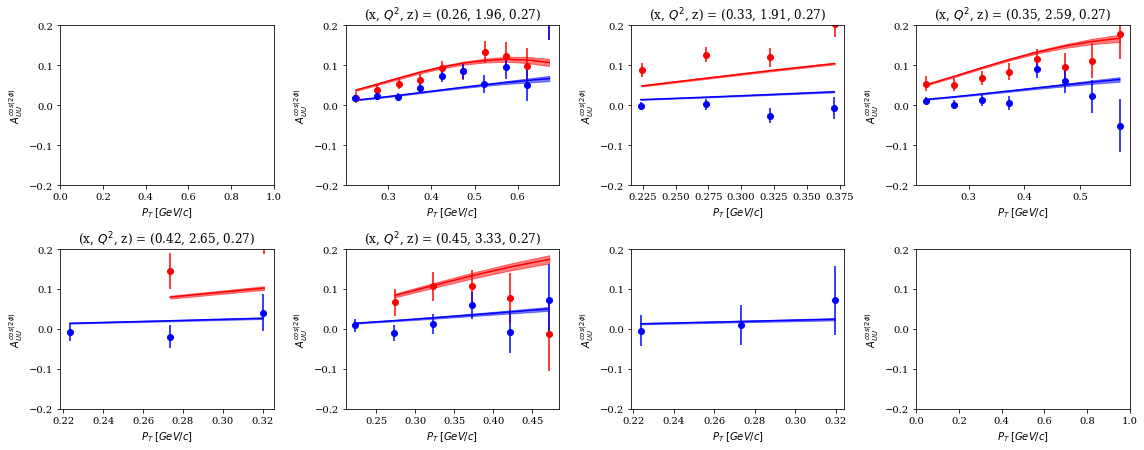

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [30]:
nx = len(x_bins)
nq = len(q2_bins)

ncol = 4
nrow = np.ceil(nx * nq / ncol) + 1

fig = plt.figure( figsize=(4*ncol, 3*nrow) )

for xb in x_bins:
    for qb in q2_bins:
        
        pad_index =  qb + (xb-1)*nq + 1
        ax = fig.add_subplot(nrow, ncol, pad_index)
        plot_clas_pt(data[7002], data[7003], xb, qb, 5, ax)
        
fig.tight_layout()
fig.savefig('/home/dmriser/Pictures/boermulders-clas-obs-with-hermes.pdf', bbox_inches='tight')